Justin Dano <br>
FE550 - Data Visualization Applications<br>
Assignment #1<br>
Due 9/13/2017<br>



#  Cryptocurrency Arbitrage  

## 1. Introduction

Arbitrage is a common trading strategy which involves the simultaneous purchase and sale of an asset with the aim to purchase from the price difference. These opportunities occur when different markets offer the same asset at different prices.<sup>(1)</sup> Given the novelty of cryptocurrencies, and the markets for which they are traded, this report aims to answer the following questions:
1. Are exchanges for the cryptocurrency Bitcoin fragmented enough that they offer arbitrage opportunities?
2. How often do these opportunities occur within a day?

The process for answering these questions involves pulling transaction data from various exchanges, then extrapolating the price of Bitcoin with a minute tick frequency. Once we have the price calculated for each exchange, we will use data visualization to achieve an intuition for the number of arbitrage opportunities over typical time-frames (e.g. hours, day). 

#### Technology Stack
Python 3.6.1 <br>
Anaconda 3-4.4.0 <br>
Pandas 0.20.3 <br>
Matplotlib 2.0.2 <br>
Developed on a Jupyter notebook.

## 2. Data retrieval

The data used for this analysis is from the Bitcoin blockchain provided by [Bitcoincharts](https://bitcoincharts.com/about/markets-api/). Bitcoincharts offers free transaction data from several exchanges. The exchanges used in this analysis are:
+ [Bitstamp](https://www.bitstamp.net/) 
+ [GDAX (Coinbase)](https://www.gdax.com/)
+ [Kraken](https://www.kraken.com/)

The data, which is a list of completed transactions, can be downloaded as a .csv file. The fields include a Unix timestamp, the asking price paid, and the amount of Bitcoin that was purchased. Although years of transaction data are provided, the data used in this report will cover about ten days.

After downloading the data, each exchange was split into 53750k-byte files. The date range for each exchange varied based on the volume of transactions. Coinbase has the largest amount of transaction volume, which created a 53750k-byte file over the ten day period June-7-2017 through June-17-2017. 

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bitstamp_df = pd.read_csv(filepath_or_buffer='/home/justin/Desktop/FALL_2017/FE550/fe550_lab1/bitstamp/xaj.csv', 
                          names=['timestamp', 'price', 'amount'])
kraken_df = pd.read_csv(filepath_or_buffer='/home/justin/Desktop/FALL_2017/FE550/fe550_lab1/kraken/xab.csv',
                        names=['timestamp', 'price', 'amount'])
coinbase_df = pd.read_csv(filepath_or_buffer='/home/justin/Desktop/FALL_2017/FE550/fe550_lab1/coinbase/xao.csv',
                          names=['timestamp', 'price', 'amount'])

In [135]:
bitstamp_df.head()

,timestamp,price,amount
0,1495803874,2514.92,1.409018
1,1495803875,2514.92,0.255144
2,1495803876,2514.93,0.026000
3,1495803877,2514.92,0.609420
4,1495803878,2514.93,2.215842


## 3. Data Transformation
First we will transfer the Unix timestamp to a readable date format.

In [136]:
bitstamp_df['timestamp'] = pd.to_datetime(bitstamp_df['timestamp'], unit='s')
kraken_df['timestamp'] = pd.to_datetime(kraken_df['timestamp'], unit='s')
coinbase_df['timestamp'] = pd.to_datetime(coinbase_df['timestamp'], unit='s')

In [137]:
bitstamp_df.head()

,timestamp,price,amount
0,2017-05-26 13:04:34,2514.92,1.409018
1,2017-05-26 13:04:35,2514.92,0.255144
2,2017-05-26 13:04:36,2514.93,0.026000
3,2017-05-26 13:04:37,2514.92,0.609420
4,2017-05-26 13:04:38,2514.93,2.215842


Next we will resample the data, aggregating to the minute frequency. This is done by taking the average price for each second-tick available for a given minute.

In [138]:
# Set index to timestamp
bitstamp_df = bitstamp_df.set_index('timestamp')
kraken_df = kraken_df.set_index('timestamp')
coinbase_df = coinbase_df.set_index('timestamp')

# Re-sample datasets to minute-tick level. Done by taking the mean
# of all prices available for each second over their corresponding minute
bitstamp_sample_df = pd.DataFrame()
kraken_sample_df = pd.DataFrame()
coinbase_sample_df = pd.DataFrame()

bitstamp_sample_df['price'] = bitstamp_df.price.resample('60S').mean()
kraken_sample_df['price'] = kraken_df.price.resample('60S').mean()
coinbase_sample_df['price'] = coinbase_df.price.resample('60S').mean()

In [139]:
bitstamp_sample_df.head()

,price
timestamp,
2017-05-26 13:04:00,2514.646923
2017-05-26 13:05:00,2511.657143
2017-05-26 13:06:00,2505.308571
2017-05-26 13:07:00,2496.558500
2017-05-26 13:08:00,2491.408696


Now we will calculate the spread between the exchanges and determine if arbitrage opportunities exist. 

In [140]:
# Combine data to one dataframe, choose Coinbase for base index as it had fewest days
price_comparison_df = coinbase_sample_df
price_comparison_df.columns = ['coinbase']
price_comparison_df['kraken'] = kraken_sample_df['price']
price_comparison_df['bitstamp'] = bitstamp_sample_df['price']

# Calcuate price differentials between exchanges
price_comparison_df['kb_spread'] = (price_comparison_df['kraken'] - price_comparison_df['bitstamp']).abs()
price_comparison_df['cb_spread'] = (price_comparison_df['coinbase'] - price_comparison_df['bitstamp']).abs()

In [141]:
price_comparison_df.head()

,coinbase,kraken,bitstamp,kb_spread,cb_spread
timestamp,,,,,
2017-07-07 15:51:00,2524.414706,2513.118778,2521.247500,8.128722,3.167206
2017-07-07 15:52:00,2524.677500,2513.698700,2522.000000,8.301300,2.677500
2017-07-07 15:53:00,2524.688571,2513.711875,2522.000000,8.288125,2.688571
2017-07-07 15:54:00,2524.890714,2513.711889,2521.873333,8.161444,3.017381
2017-07-07 15:55:00,2525.412857,2513.712000,2524.216000,10.504000,1.196857


## 4. Data Analysis

For this analysis, an arbitrage opportunity has been defined as a price differential of at least $10. Bitcoin transaction fees for the exchanges cap out around 0.25%, but fees for exchanging Bitcoin to fiat currency are around 4-6%.<sup>(2)</sup><sup>(3)</sup><sup>(4)</sup> To start, focus will be on one day chosen at random, July 10th, 2017. The plot will be split into two 12-hour intervals. Next a closer look with be done for an active time-frame for one of the strategies. The two crosses to be compared are:
1. Coinbase and Bitstamp
2. Kraken and Bitstamp 

### First 12 hour interval: July 10th, 2017 

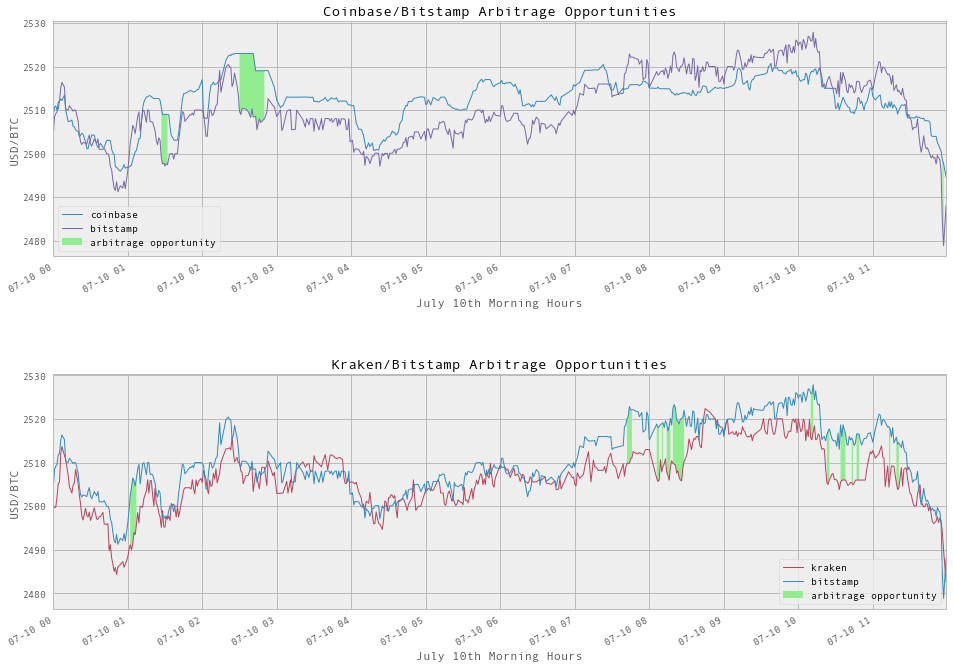

In [142]:
# Plot a sample showing arbitrage opportunities
plot_sample = price_comparison_df[(price_comparison_df.index >= '2017-07-10 00:00') 
                                  & (price_comparison_df.index <= '2017-07-10 12:00')]

plot_sample = plot_sample.dropna()

# First 12-hour interval of July 10th for Coinbase and Bitsamp
fig = plt.figure(figsize=(16,12))
fig.add_subplot(211)
ax = plot_sample['coinbase'].plot()
plot_sample['bitstamp'].plot(ax=ax)

ax.fill_between(
        x=plot_sample.index,
        y1=plot_sample['coinbase'],
        y2=plot_sample['bitstamp'],
        where=plot_sample['cb_spread'] > 10,
        facecolor='lightgreen',
        label='arbitrage opportunity'
    )
ax.legend()
ax.set_title('Coinbase/Bitstamp Arbitrage Opportunities')
ax.set_xlabel('July 10th Morning Hours')
ax.set_ylabel('USD/BTC')

# First 12-hour interval of July 10th for Kraken and Bitsamp
fig.add_subplot(212)
ax = plot_sample['kraken'].plot(color='#B9445D')
plot_sample['bitstamp'].plot(ax=ax)

ax.fill_between(
        x=plot_sample.index,
        y1=plot_sample['kraken'],
        y2=plot_sample['bitstamp'],
        where=plot_sample['kb_spread'] > 10,
        facecolor='lightgreen',
        label='arbitrage opportunity'
    )
ax.legend()
ax.set_title('Kraken/Bitstamp Arbitrage Opportunities')
ax.set_xlabel('July 10th Morning Hours')
ax.set_ylabel('USD/BTC')

Both strategies appear to show some potential for arbitrage opportunities in the first half of the day. Although Coinbase/Bitstamp only produced a few opportunities, Kraken/Bitstamp showed about a dozen. It is also interesting to note that the Coinbase and Bitstamp exchanges both traded the higher price for portions of the day, while Kraken was almost consistently the cheaper market relative to Bitstamp. These could be indications of particular market-microstructure patterns to examine in future research.

Now zooming in on Kraken/Bitstamp from 7:00am - 12:00pm to get a better look at the arbitrage opportunities.

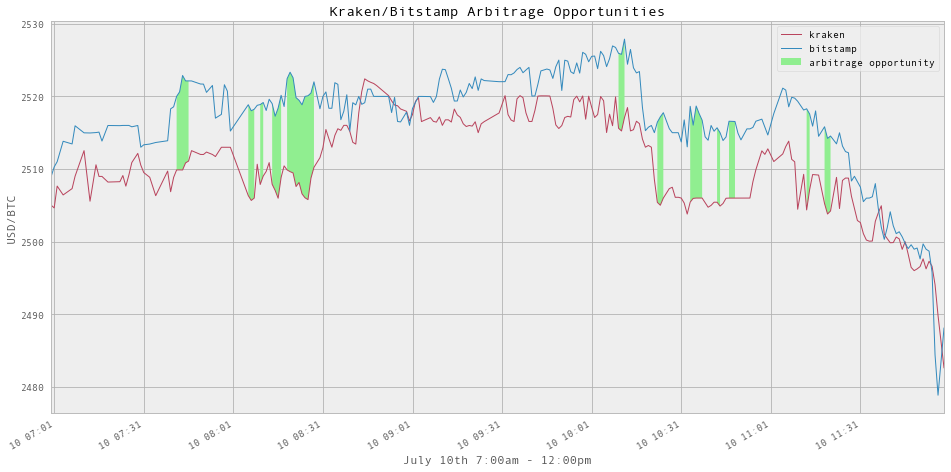

In [143]:
# Plot a sample showing arbitrage opportunities
plot_sample = price_comparison_df[(price_comparison_df.index >= '2017-07-10 07:00') 
                                  & (price_comparison_df.index <= '2017-07-10 12:00')]

plot_sample = plot_sample.dropna()

fig = plt.figure(figsize=(16,8))
fig.add_subplot()
ax = plot_sample['kraken'].plot(color='#B9445D')
plot_sample['bitstamp'].plot(ax=ax)

ax.fill_between(
        x=plot_sample.index,
        y1=plot_sample['kraken'],
        y2=plot_sample['bitstamp'],
        where=plot_sample['kb_spread'] > 10,
        facecolor='lightgreen',
        label='arbitrage opportunity'
    )
ax.legend()
ax.set_title('Kraken/Bitstamp Arbitrage Opportunities')
ax.set_xlabel('July 10th 7:00am - 12:00pm')
ax.set_ylabel('USD/BTC')

One thing that stands out is the duration of these opportunities. While there are a few opportunities that exceed 10 minutes, most opportunities only last a few minutes in the first 12-hour interval. Slippage and time to execute trades are yet to be determined, but are important considerations before implementing a trading strategy. Future assignments may look to analyze slippage, and duration of arbitrage opportunities. 

###  Second 12 hour interval : July 10th, 2017 

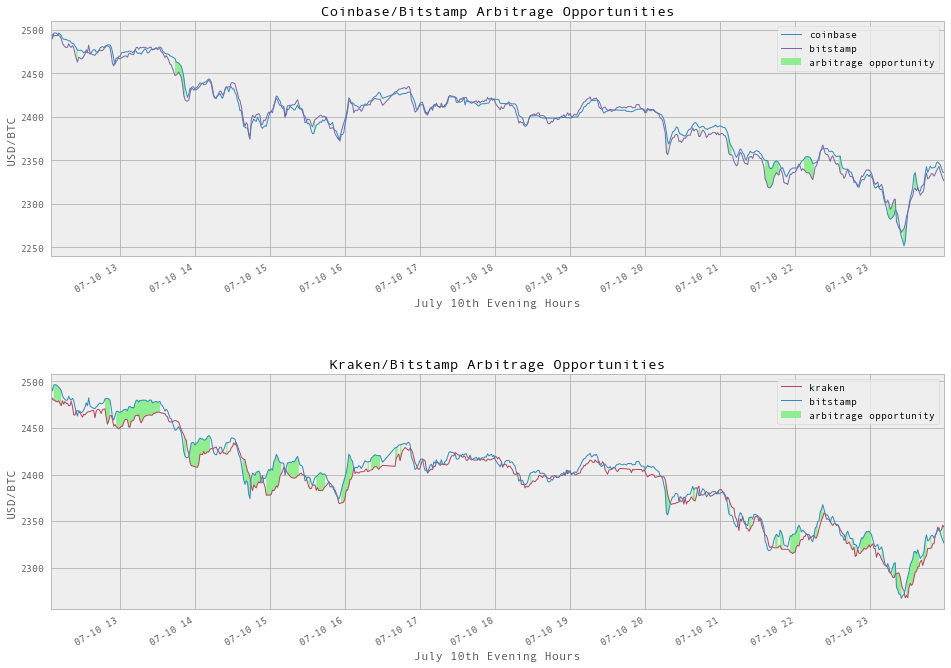

In [144]:
# Plot a sample showing arbitrage opportunities
plot_sample2 = price_comparison_df[(price_comparison_df.index >= '2017-07-10 12:00') 
                                  & (price_comparison_df.index <= '2017-07-10 23:59')]

plot_sample2 = plot_sample2.dropna()

# Second 12-hour interval of July 10th for Coinbase and Bitsamp
fig = plt.figure(figsize=(16,12))
fig.add_subplot(211)
ax = plot_sample2['coinbase'].plot()
plot_sample2['bitstamp'].plot(ax=ax)

ax.fill_between(
        x=plot_sample2.index,
        y1=plot_sample2['coinbase'],
        y2=plot_sample2['bitstamp'],
        where=plot_sample2['cb_spread'] > 10,
        facecolor='lightgreen',
        label='arbitrage opportunity'
    )
ax.legend()
ax.set_title('Coinbase/Bitstamp Arbitrage Opportunities')
ax.set_xlabel('July 10th Evening Hours')
ax.set_ylabel('USD/BTC')

# Second 12-hour interval of July 10th for Kraken and Bitsamp
fig.add_subplot(212)
ax = plot_sample2['kraken'].plot(color='#B9445D')
plot_sample2['bitstamp'].plot(ax=ax)

ax.fill_between(
        x=plot_sample2.index,
        y1=plot_sample2['kraken'],
        y2=plot_sample2['bitstamp'],
        where=plot_sample2['kb_spread'] > 10,
        facecolor='lightgreen',
        label='arbitrage opportunity'
    )
ax.legend()
ax.set_title('Kraken/Bitstamp Arbitrage Opportunities')
ax.set_xlabel('July 10th Evening Hours')
ax.set_ylabel('USD/BTC')

The first thing that stood out about the afternoon session is the huge price fluctuation of about 150 USD, compared to the 30 USD range spanning the morning hours. This provides an interesting view on how arbitrage opportunities occur in a more volatile market. Coinbase and Bitstamp markets provide several opportunities in the afternoon, with each market leading in price for portions of the day. Once again, Kraken has been the cheaper market almost the entire afternoon, providing several opportunities for arbitrage. The duration of opportunities for the Kraken/Bitstamp spread increased quite a bit from the morning. Let us take a closer look at the Kraken/Bitstamp from 12:00pm to 4:00pm.

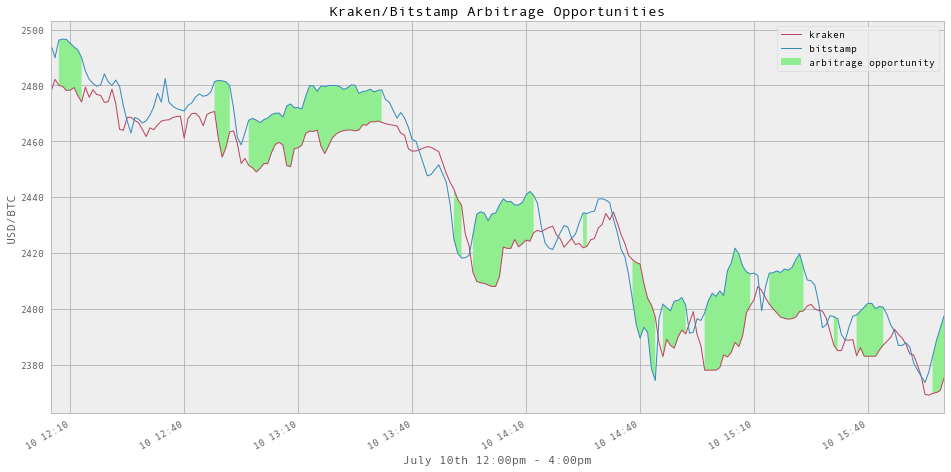

In [145]:
# Plot a sample showing arbitrage opportunities
plot_sample = price_comparison_df[(price_comparison_df.index >= '2017-07-10 12:00') 
                                  & (price_comparison_df.index <= '2017-07-10 16:00')]

plot_sample = plot_sample.dropna()

fig = plt.figure(figsize=(16,8))
fig.add_subplot()
ax = plot_sample['kraken'].plot(color='#B9445D')
plot_sample['bitstamp'].plot(ax=ax)

ax.fill_between(
        x=plot_sample.index,
        y1=plot_sample['kraken'],
        y2=plot_sample['bitstamp'],
        where=plot_sample['kb_spread'] > 10,
        facecolor='lightgreen',
        label='arbitrage opportunity'
    )
ax.legend()
ax.set_title('Kraken/Bitstamp Arbitrage Opportunities')
ax.set_xlabel('July 10th 12:00pm - 4:00pm')
ax.set_ylabel('USD/BTC')

Just from looking at this visual, a hypothesis for an algorithmic trading strategy might be worth investigating. Several times following Bitstamps price dropping under Krakens, it is followed by a reversal where a sharp drop in Krakens price leads to an arbitrage opportunity. When thinking about this intuitively, it makes economic sense given that Kraken is the smaller exchange, so it will take longer to react to news or any new information made public that affects the price of Bitcoin. Any pattern observed like this would need to be thoroughly backtested over larger periods of historic data before warranting an investment.

## 5. Conclusion

The data and visuals have provided some encouraging results, (i.e. that arbitrage opportunities between Bitcoin exchanges may in fact exist). Future work includes looking at the duration of these opportunities and the cost-analysis to determine how large of a spread would be needed to actually turn a profit. Some exchanges also offer leverage and short-selling which give additional flexibility for potential trading strategies. Another consideration that would be needed before developing a trading strategy includes analyzing the order book to gauge the available liquidity.

References: <br>
    (1) http://www.investopedia.com/terms/a/arbitrage.asp  
    (2) https://support.coinbase.com/customer/portal/articles/2109597-buy-sell-bank-transfer-fees    
    (3) https://www.bitstamp.net/fee_schedule/  
    (4) https://www.kraken.com/help/fees <br>
    